In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Data/Faces.zip

Archive:  /content/drive/MyDrive/Data/Faces.zip
   creating: Faces/
  inflating: Faces/rename.py         
   creating: Faces/WiderSelected/
  inflating: Faces/WiderSelected/annotations.txt  
  inflating: Faces/WiderSelected/README.md  
   creating: Faces/WiderSelected/train/
   creating: Faces/WiderSelected/train/0--Parade/
  inflating: Faces/WiderSelected/train/0--Parade/0.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/1.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/10.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/11.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/12.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/13.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/14.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/15.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/16.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/17.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/18.jpg  
  inflating: Faces/WiderSelected/train

In [ ]:
# Required Packages

import cv2
import os
import matplotlib.pyplot as plt
import random
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
data_name = "Faces/WiderSelected"

In [ ]:
new_heigth, new_width = 200, 200
train_images=[]
train_labels=[]
iteration_size = 30

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
def prepare_data(start, end):
    train_images.clear()
    train_labels.clear()
    os.chdir("/content/%s/"%data_name)
    ann = open("./annotations.txt", 'r')
    lines = ann.readlines()
    pointer = 0
    pbar = tqdm(total=end)
    counter_l = 0
    while pointer != len(lines):
        if counter_l == end:
            break
        if start < counter_l < end:
            path = lines[pointer][:-1]
            os.chdir("/content/Faces")
            image = cv2.imread(path)
            cur_heigth, cur_width = image.shape[:2]
            image = cv2.resize(image, (new_width, new_heigth), fx=(new_width/cur_width), fy=(new_heigth/cur_heigth), interpolation=cv2.INTER_CUBIC)
            pointer += 1
            n = int(lines[pointer])
            pointer += 1
            gtvalues = []
            for i in range(n):
                temp = lines[pointer].split()
                temp = [int(t) for t in temp]
                x, y, w, h = temp[0], temp[1], temp[2], temp[3]
                x, y = int(x * new_width / cur_width), int(y * new_heigth / cur_heigth)
                w, h = int(w * new_width / cur_width), int(h * new_heigth / cur_heigth)
                gtvalues.append({"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                pointer += 1
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast  ( base_k = 50,
                                            inc_k = 50,
                                            sigma = 0.8 
                                            )
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        flag = 1
        else:
            pointer += 1
            n = int(lines[pointer])
            pointer += 1
            for i in range(n):
                pointer += 1
        counter_l += 1
        pbar.update(1)
    pbar.close()
    ann.close()

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
def show_predicted(start, end):
    os.chdir("/content/%s/"%data_name)
    ann = open("./annotations.txt", 'r')
    lines = ann.readlines()
    pointer = 0

    counter_l = 0
    while pointer != len(lines):
        if counter_l == end:
            break
        if counter_l < start:
            pointer += 1
            n = int(lines[pointer])
            pointer += 1
            for i in range(n):
                pointer += 1
        else:
            path = lines[pointer][:-1]
            os.chdir("/content/Faces")
            image = cv2.imread(path)
            cur_heigth, cur_width = image.shape[:2]
            image = cv2.resize(image, (new_width, new_heigth), fx=(new_width/cur_width), fy=(new_heigth/cur_heigth), interpolation=cv2.INTER_CUBIC)
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            pointer += 1
            n = int(lines[pointer])
            pointer += 1
            imout = imout[:, :, ::-1]
            imout = np.ascontiguousarray(imout, dtype=np.uint8)
            for e,result in enumerate(ssresults):
                if e < 2000:
                    x,y,w,h = result
                    timage = imout[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    img = np.expand_dims(resized, axis=0)
                    out = model_final.predict(img)
                    if out[0][0] > 0.55:
                        cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            plt.rcParams['figure.figsize'] = [5, 5]
            plt.figure()
            plt.imshow(imout)
            plt.show()
            for i in range(n):
                pointer += 1

        counter_l += 1
    ann.close()

Iteration 1th
Loading the 1th data part


100%|██████████| 30/30 [00:12<00:00,  2.47it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.8947 - accuracy: 0.8469
Epoch 1: val_loss improved from inf to 0.21898, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 41s 3s/step - loss: 0.8947 - accuracy: 0.8469 - val_loss: 0.2190 - val_accuracy: 0.9062
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9531
Epoch 2: val_loss improved from 0.21898 to 0.17992, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 12s 1s/step - loss: 0.1451 - accuracy: 0.9531 - val_loss: 0.1799 - val_accuracy: 0.9219
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9750
Epoch 3: val_loss did not improve from 0.17992
10/10 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9812
Epoch 4: val_loss improved from 0.17992 to 0.04955, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 18s 2s/step - loss: 0.0659 - accura

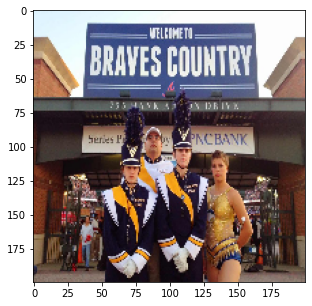

Iteration 2th
Loading the 2th data part


100%|██████████| 60/60 [00:11<00:00,  5.09it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.9403
Epoch 1: val_loss improved from inf to 0.03263, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 20s 2s/step - loss: 0.1919 - accuracy: 0.9403 - val_loss: 0.0326 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9750
Epoch 2: val_loss did not improve from 0.03263
10/10 [==============================] - 5s 514ms/step - loss: 0.1118 - accuracy: 0.9750 - val_loss: 0.0445 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9625
Epoch 3: val_loss did not improve from 0.03263
10/10 [==============================] - 5s 522ms/step - loss: 0.1159 - accuracy: 0.9625 - val_loss: 0.2152 - val_accuracy: 0.8750
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9717
Epoch 4: val_loss improved from 0.03263 to 0.00079, savin

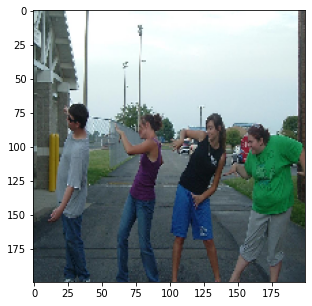

Iteration 3th
Loading the 3th data part


100%|██████████| 90/90 [00:11<00:00,  8.12it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9812
Epoch 1: val_loss improved from inf to 0.10207, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 18s 2s/step - loss: 0.0991 - accuracy: 0.9812 - val_loss: 0.1021 - val_accuracy: 0.9688
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9844
Epoch 2: val_loss did not improve from 0.10207
10/10 [==============================] - 5s 522ms/step - loss: 0.0443 - accuracy: 0.9844 - val_loss: 0.1060 - val_accuracy: 0.9844
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9812
Epoch 3: val_loss did not improve from 0.10207
10/10 [==============================] - 6s 598ms/step - loss: 0.0492 - accuracy: 0.9812 - val_loss: 0.1043 - val_accuracy: 0.9688
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9934
Epoch 4: val_loss improved from 0.10207 to 0.05693, savin

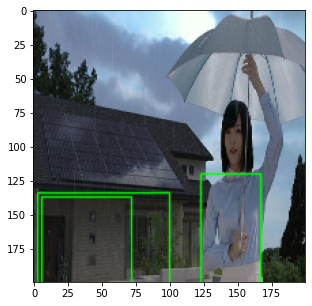

Iteration 4th
Loading the 4th data part


100%|██████████| 120/120 [00:12<00:00,  9.58it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9701
Epoch 1: val_loss improved from inf to 0.09283, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 16s 2s/step - loss: 0.1644 - accuracy: 0.9701 - val_loss: 0.0928 - val_accuracy: 0.9688
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9781
Epoch 2: val_loss improved from 0.09283 to 0.06610, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 12s 1s/step - loss: 0.0925 - accuracy: 0.9781 - val_loss: 0.0661 - val_accuracy: 0.9688
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9668
Epoch 3: val_loss improved from 0.06610 to 0.02589, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 13s 1s/step - loss: 0.0800 - accuracy: 0.9668 - val_loss: 0.0259 - val_accuracy: 0.9844
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1255 - 

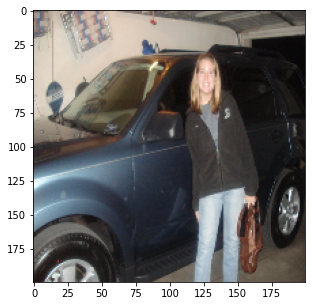

Iteration 5th
Loading the 5th data part


100%|██████████| 150/150 [00:11<00:00, 13.27it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9875
Epoch 1: val_loss improved from inf to 0.02548, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 16s 2s/step - loss: 0.0337 - accuracy: 0.9875 - val_loss: 0.0255 - val_accuracy: 0.9844
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9875
Epoch 2: val_loss improved from 0.02548 to 0.00375, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 12s 1s/step - loss: 0.1011 - accuracy: 0.9875 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9688
Epoch 3: val_loss did not improve from 0.00375
10/10 [==============================] - 6s 560ms/step - loss: 0.0865 - accuracy: 0.9688 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9844
Epoch 4: val_loss di

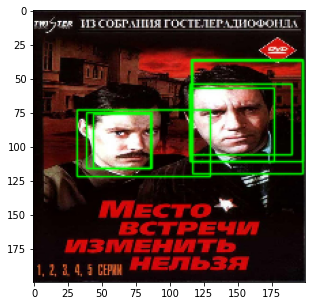

Iteration 6th
Loading the 6th data part


100%|██████████| 180/180 [00:11<00:00, 15.92it/s] 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9500
Epoch 1: val_loss improved from inf to 0.12121, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 17s 2s/step - loss: 0.2366 - accuracy: 0.9500 - val_loss: 0.1212 - val_accuracy: 0.9219
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9897
Epoch 2: val_loss improved from 0.12121 to 0.07900, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 12s 1s/step - loss: 0.0635 - accuracy: 0.9897 - val_loss: 0.0790 - val_accuracy: 0.9531
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9594
Epoch 3: val_loss improved from 0.07900 to 0.06383, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 12s 1s/step - loss: 0.1070 - accuracy: 0.9594 - val_loss: 0.0638 - val_accuracy: 0.9531
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0402 - 

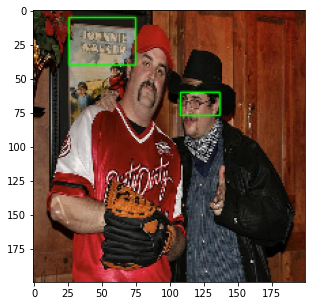

Iteration 7th
Loading the 7th data part


100%|██████████| 210/210 [00:11<00:00, 18.38it/s] 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9750
Epoch 1: val_loss improved from inf to 0.06773, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 17s 2s/step - loss: 0.0701 - accuracy: 0.9750 - val_loss: 0.0677 - val_accuracy: 0.9688
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9844
Epoch 2: val_loss did not improve from 0.06773
10/10 [==============================] - 5s 512ms/step - loss: 0.0425 - accuracy: 0.9844 - val_loss: 0.0761 - val_accuracy: 0.9688
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9906
Epoch 3: val_loss improved from 0.06773 to 0.06482, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 13s 1s/step - loss: 0.0241 - accuracy: 0.9906 - val_loss: 0.0648 - val_accuracy: 0.9844
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9812
Epoch 4: val_loss di

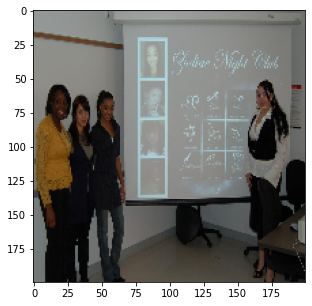

Iteration 8th
Loading the 8th data part


100%|██████████| 240/240 [00:11<00:00, 21.15it/s] 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9937
Epoch 1: val_loss improved from inf to 0.01849, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 20s 2s/step - loss: 0.0506 - accuracy: 0.9937 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9625
Epoch 2: val_loss did not improve from 0.01849
10/10 [==============================] - 5s 513ms/step - loss: 0.1531 - accuracy: 0.9625 - val_loss: 0.0434 - val_accuracy: 0.9844
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9812
Epoch 3: val_loss did not improve from 0.01849
10/10 [==============================] - 7s 706ms/step - loss: 0.0741 - accuracy: 0.9812 - val_loss: 0.0348 - val_accuracy: 0.9844
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9842
Epoch 4: val_loss did not improve from 0.01849
10/10 [===

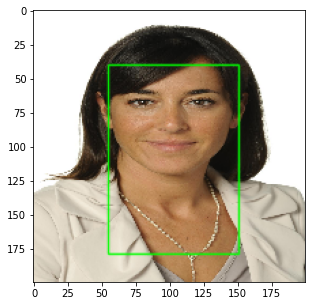

Iteration 9th
Loading the 9th data part


100%|██████████| 270/270 [00:11<00:00, 23.33it/s] 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9469
Epoch 1: val_loss improved from inf to 0.10302, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 22s 2s/step - loss: 0.1979 - accuracy: 0.9469 - val_loss: 0.1030 - val_accuracy: 0.9688
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9531
Epoch 2: val_loss improved from 0.10302 to 0.09116, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 13s 1s/step - loss: 0.1213 - accuracy: 0.9531 - val_loss: 0.0912 - val_accuracy: 0.9531
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9654
Epoch 3: val_loss improved from 0.09116 to 0.07891, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 13s 1s/step - loss: 0.0884 - accuracy: 0.9654 - val_loss: 0.0789 - val_accuracy: 0.9375
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1051 - 

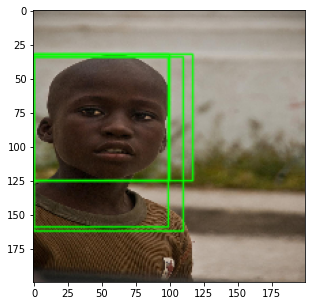

Iteration 10th
Loading the 10th data part


100%|██████████| 300/300 [00:11<00:00, 26.37it/s] 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9563
Epoch 1: val_loss improved from inf to 0.07093, saving model to ieeercnn_vgg16.h5
10/10 [==============================] - 25s 3s/step - loss: 0.1391 - accuracy: 0.9563 - val_loss: 0.0709 - val_accuracy: 0.9688
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9700
Epoch 2: val_loss did not improve from 0.07093
10/10 [==============================] - 6s 628ms/step - loss: 0.0909 - accuracy: 0.9700 - val_loss: 0.1310 - val_accuracy: 0.9688
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9719
Epoch 3: val_loss did not improve from 0.07093
10/10 [==============================] - 7s 685ms/step - loss: 0.0666 - accuracy: 0.9719 - val_loss: 0.1651 - val_accuracy: 0.9219
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9844
Epoch 4: val_loss did not improve from 0.07093
10/10 [===

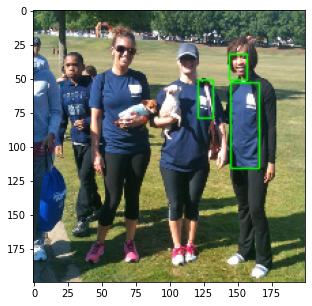

In [ ]:
# Training Loop
for i in range(10):
    print("Iteration %dth"%(i + 1))
    print("Loading the %dth data part"%(i + 1))
    prepare_data(iteration_size*i, iteration_size*(i + 1))
    X_new = np.array(train_images)
    y_new = np.array(train_labels)
    lenc = MyLabelBinarizer()
    Y =  lenc.fit_transform(y_new)
    X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
    trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    traindata = trdata.flow(x=X_train, y=y_train)
    tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    testdata = tsdata.flow(x=X_test, y=y_test)
    os.chdir("/content/drive/MyDrive/Weights")
    checkpoint = ModelCheckpoint("ieeercnn_vgg16.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

    hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])
    
    print("Predicting...")
    show_predicted(iteration_size*(i + 1), iteration_size*(i + 1) + 1)

In [ ]:
def dataset_predict(directory, start, end):
    index = random.randint(start, end)
    os.chdir("/content/%s/"%data_name)
    ann = open("./annotations.txt", 'r')
    lines = ann.readlines()
    pointer = 0


    while pointer != len(lines):
        path = lines[pointer][:-1]
        if path != "/content/%s/train/%s/%d.jpg"%(data_name, directory, index):
            pointer += 1
            n = int(lines[pointer])
            pointer += 1
            for i in range(n):
                pointer += 1
        else:
            os.chdir("/content/Faces")
            image = cv2.imread(path)
            cur_heigth, cur_width = image.shape[:2]
            image = cv2.resize(image, (new_width, new_heigth), fx=(new_width/cur_width), fy=(new_heigth/cur_heigth), interpolation=cv2.INTER_CUBIC)
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            pointer += 1
            n = int(lines[pointer])
            pointer += 1
            for e,result in enumerate(ssresults):
                if e < 2000:
                    x,y,w,h = result
                    timage = imout[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    img = np.expand_dims(resized, axis=0)
                    out= model_final.predict(img)
                    if out[0][0] > 0.50:
                        cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            imout = imout[:, :, ::-1]
            plt.rcParams['figure.figsize'] = [10, 10]
            print(imout)
            plt.figure()
            plt.imshow(imout)
            plt.show()
            for i in range(n):
                pointer += 1

    ann.close()

In [ ]:
dataset_predict("0--Parade", 100, 222)

0.9444377 78 3 69 78
0.95024586 56 3 80 62
0.85148853 42 3 94 103
0.86229336 40 3 99 94
0.92027676 65 27 61 35


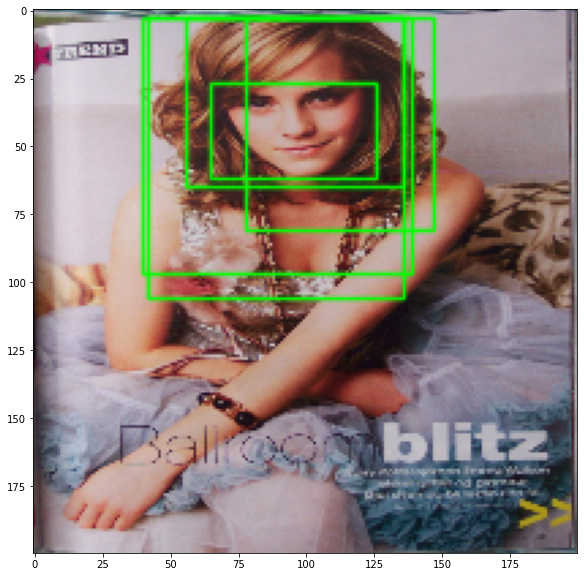

In [ ]:
path = "/content/Faces/WiderSelected/train/0--Parade/1.jpg"

image = cv2.imread(path)
cur_heigth, cur_width = image.shape[:2]
image = cv2.resize(image, (new_width, new_heigth), fx=(new_width/cur_width), fy=(new_heigth/cur_heigth), interpolation=cv2.INTER_CUBIC)
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = image.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        if out[0][0] > 0.85:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            print(out[0][0], x, y, w, h)
imout = imout[:, :, ::-1]
plt.rcParams['figure.figsize'] = [10, 10]
plt.figure()
plt.imshow(imout)
plt.show()

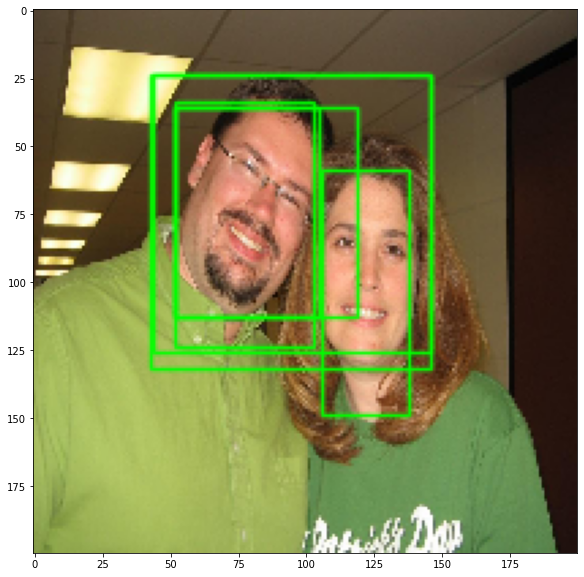

In [ ]:
directory = "0--Parade"
start, end = 0, 64

dataset_predict(directory, start, end)